In [264]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest

from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns

from pivottablejs import pivot_ui
from IPython.display import HTML
import requests

%matplotlib inline

The dataset we were given shows how much a wine from a specific wine year costs at the time of data extraction, which is 2020.
For each data entry we have additional geographical features (region, country and winery) as well as Rating and NumberOfRatings.
We need to enhance this dataset with data from previous years and add more features like grape, climate and so on.. to get an accurate prediction. However there was not enough time to acquire the correct data so in this notebook we will use the data at hand to implement a solution to the problems stated below.
We will view the column vintage year as year and we will treat wines from different vintages as if it was the same wine.

The poblems we would like to solve are
- How much will a certain wine cost in n years time?
- How do we seperate our budget when investing in such wines?
- In what do we invest to get a big return as fast as possible?
- Is the rating important?


# Data acquisition

To have an accurate model we need to add more data to the dataset:
- Data from years before 2020
- More features of the wine (alcohol percentage, grape...)
- More geographical features (climate...)

In [92]:
r = requests.get(
    "https://www.vivino.com/api/explore/explore",
    params={
        "currency_code": "EUR",
        "order_by": "price",
        "order": "asc",
        "page": 1,
        "wine_type_ids[]": "1",
    },
    headers={
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0"
    },
)

results = [
    (
        t["vintage"]["wine"]["winery"]["name"],
        t["vintage"]["year"],
        t["vintage"]["wine"]['region']["country"]["name"],
        t["vintage"]["statistics"]["ratings_average"],
        t["price"]["amount"],
        t["vintage"]["wine"]["vintage_type"],
        t["vintage"]["wine"]["region"]["name"]
    )
    for t in r.json()["explore_vintage"]["matches"]
]
dataframe = pd.DataFrame(
    results,
    columns=["Winery", "Year", "Country", "Rating", "Price", "?", "Region"],
)

TypeError: 'NoneType' object is not subscriptable

In [224]:
#read csv files
red = pd.read_csv(r".\2021_crunch_data_science_consultant\Red.csv")
rose = pd.read_csv(r".\2021_crunch_data_science_consultant\Rose.csv")
sparkling = pd.read_csv(r".\2021_crunch_data_science_consultant\Sparkling.csv")
white = pd.read_csv(r".\2021_crunch_data_science_consultant\White.csv")
varieties = pd.read_csv(r".\2021_crunch_data_science_consultant\Varieties.csv")

## Data shape

In [ ]:
#shape
red.shape

In [ ]:
rose.shape

In [ ]:
sparkling.shape

In [ ]:
white.shape

In [93]:
varieties.shape

(1512, 1)

# Data distribution

In this section we will look at the original distribution of the data (mean, median, variance etc.) to get a good view of what we are working with.

### Add wine type

In [225]:
red['Type'] = 'red'
rose['Type'] = 'rose'
sparkling['Type'] = 'sparkling'
white['Type'] = 'white'

### Concatenate wines

In [226]:
wines = pd.concat([red, rose, sparkling, white])
wines.shape

(13834, 9)

### Describe

The describe function tells us the distribution per column.
We will group the dataframe by year and country to get a view of what the data looks like in each of those groupings.

##### Price

We see that there is an uneven distribution per year. More recent years are far more present in the dataset than older ones. The older the wine, the more expensive in general.
The variance varies greatly per year, no decreasing or increasing trend can be seen but since there is not enough data for the older wines, this conclusion is not reliable. The youngest wines have a very small spread, new wines are probably initially set at a standard price.

##### NumberOfRatings

The variance here is very large within each year because some wines get a lot of ratings and others don't. This shows which wines are more popular than others.

The Minimum number of ratings is 25 up to and including 2011. This probabaly is some kind of minimum criteria of Vivino. 

The minimum increases for older wines which could mean that a smaller number of wines are rated, so all the ratings are given to a select few wines.

##### Ratings

The dataset contains more recent wines, so the amount of ratings is also higher in recent years. 
Vivino hasn't been around that long either, so new wines will have more tasters than the older ones because people mostly like to try something new.

the standard deviation is rather small, all the data points are centered around the mean. It is not possible to deviate much here because of the small range of ratings (0-5).

In [96]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df = wines.groupby('Year').describe()
    print(df.to_string())

      Rating                                                   NumberOfRatings                                                                      Price                                                                         
       count      mean       std  min    25%   50%    75%  max           count         mean          std    min     25%     50%      75%      max   count         mean         std     min       25%       50%        75%      max
Year                                                                                                                                                                                                                              
1961     3.0  3.866667  0.057735  3.8  3.850  3.90  3.900  3.9             3.0   246.666667   194.423078   37.0  159.50   282.0   351.50    421.0     3.0    18.920000    0.975038   17.95   18.4300    18.910    19.4050    19.90
1988     1.0  4.300000       NaN  4.3  4.300  4.30  4.300  4.3             1.0   203.000000 

##### Price

In some countries prices are very spread out, in others not so much. The minimum price is relatively high in some countries, this could be because they only have 1 wine for example.
In the real wine countries like France, Italy and Spain the mean is very high.

##### NumberOfRatings

The variance here is mostly big for each country because some wines get a lot of ratings and others don't.

Wines from certain countries are more popular than others so those ones will get more ratings which raises the mean.

##### Rating

The spread of the rating is per country also not big for the same reason, there are only values from 0 to 5.
Some countries have a higher average rating than others, but this is not that reliable because they may have only 1 wine.

In [97]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    df = wines.groupby('Country').describe()
    print(df.to_string())

                Rating                                                   NumberOfRatings                                                                        Price                                                                 
                 count      mean       std  min    25%   50%    75%  max           count         mean          std     min      25%     50%      75%      max   count       mean         std    min      25%     50%      75%      max
Country                                                                                                                                                                                                                               
Argentina        308.0  3.814610  0.338055  2.9  3.600  3.80  4.000  4.6           308.0   779.188312  1355.957182    25.0   112.75   299.5   747.25  11920.0   308.0  20.918669   24.943473   4.78   8.4100  12.720  21.6425   273.71
Australia        318.0  3.788050  0.324764  3.0  3.600  3.80  4.000  4.6    

### Labelencoder

Machine learning algorithms need numerical data so we have to encode the categorical columns to numbers with the label encoder.

In [182]:
def label(df):
    le = preprocessing.LabelEncoder()
    column = df.columns
    print(column)
    l = df.values
    
    for i in range(0,len(l[0])):
        l[:,i] = le.fit_transform(l[:,i])
    
    return l

In [184]:
npWines = label(wines.loc[:, ['Name', 'Country', 'Region', 'Winery','Type']])
npWines = np.concatenate((npWines, wines.loc[:, ['Year','NumberOfRatings', 'Rating', 'Price']]), axis=1)

Index(['Name', 'Country', 'Region', 'Winery', 'Type'], dtype='object')


In [186]:
npWines.shape

(13834, 9)

#### Distribution per feature

We transform the numpy array to a dataframe object again

In [187]:
winesLabel = pd.DataFrame(npWines, columns = wines.columns)
winesLabel.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,Type
0,7343,10,574,791,0,2011,100,4.2,95.0
1,5677,10,404,891,0,2017,100,4.3,15.5
2,3457,16,748,2809,0,2015,100,3.9,7.45
3,753,16,61,559,0,2019,100,3.5,8.72
4,7992,2,143,2289,0,2016,100,3.9,29.15


The column year has a string value 'N.V.' so we can't treat the column as integers as long as that value is there. We will drop those values in the winesLabel dataframe. This is further analyzed in a coming section.

In [188]:
winesLabel = winesLabel.drop(winesLabel[winesLabel.Year == 'N.V.'].index)
winesLabel.shape

(13834, 9)

In [189]:
winesLabel["Name"] = winesLabel["Name"].astype(int)
winesLabel["Country"] = winesLabel["Country"].astype(int)
winesLabel["Region"] = winesLabel["Region"].astype(int)
winesLabel["Winery"] = winesLabel["Winery"].astype(int)
winesLabel["Price"] = winesLabel["Price"].astype(int)
winesLabel["Year"] = winesLabel["Year"].astype(int)
winesLabel["Type"] = winesLabel["Type"].astype(int)
winesLabel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13834 entries, 0 to 13833
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             13834 non-null  int32 
 1   Country          13834 non-null  int32 
 2   Region           13834 non-null  int32 
 3   Winery           13834 non-null  int32 
 4   Rating           13834 non-null  object
 5   NumberOfRatings  13834 non-null  object
 6   Price            13834 non-null  int32 
 7   Year             13834 non-null  int32 
 8   Type             13834 non-null  int32 
dtypes: int32(7), object(2)
memory usage: 594.6+ KB


There is an uneven distribution for vintage, region, country and winery.
vintage:
We need more data points from certain vintages because if there is too little (yearly) data for a wine, we cannot learn the evolution over time properly.

Certain regions are more present because there are more wines from these areas as they are more popular, so this may be biased. But that is not a bad thing because in real life this bias also exists.

We also have a very unequal distribution by type of wine. The unequal distribution is not the issue, but if there are not enough data points for a certain wine type, the algorithmn can't learn relations between them. For example rose wine from a certain region may raise faster in price.

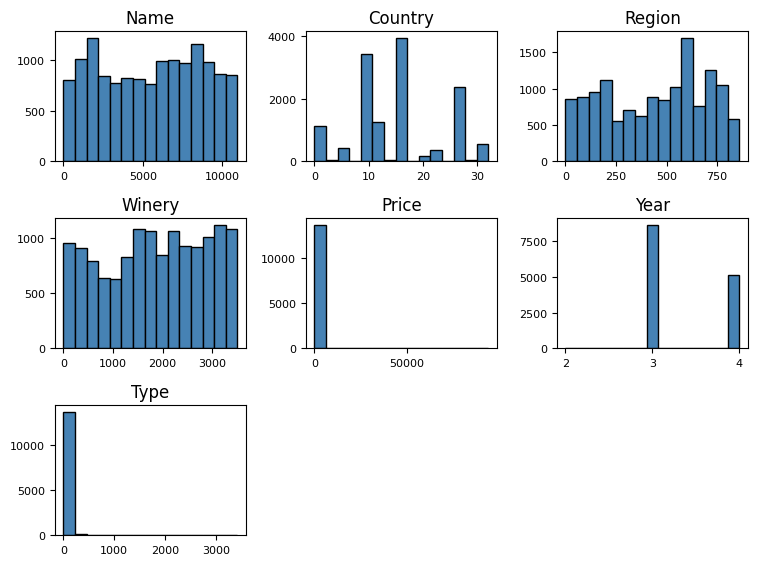

In [190]:
winesLabel.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

#### 2D correlation

We can conclude that there is a relationship between rating and price. An increase in the rating usually results in a rising price and vice versa. 
There is also a correlation between the geographical features (region, country and winery). These are categorical variables and therefore cannot be shown in this matrix. A winery belongs to a region which in turn belongs to a country, so they will often have the same characteristics. If the price increases in a region, the (average) price in a country will also increase.

C:\Users\elise\AppData\Local\Temp\ipykernel_19600\3262419491.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = wines.corr()


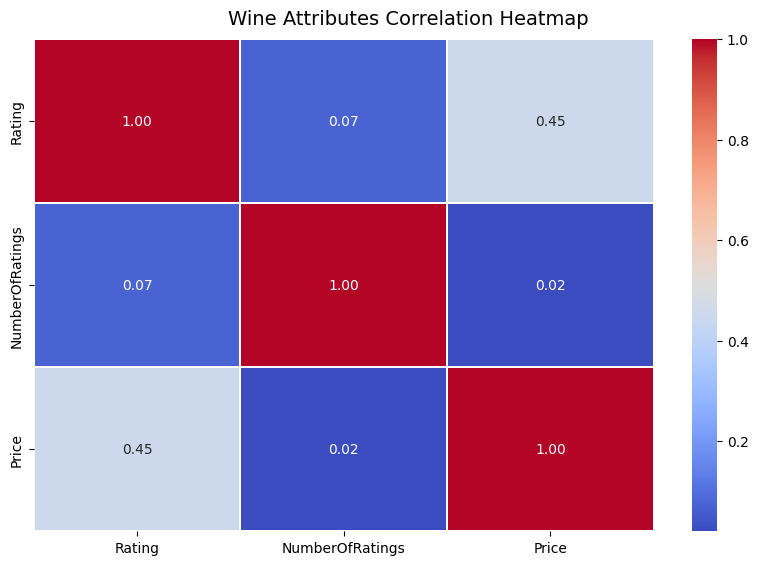

In [191]:
# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(10, 6))
corr = wines.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

In a 2D pairwise plot we can see the relation of every feature paired with eachother. 

C:\Users\elise\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\elise\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\elise\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\elise\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
C:\Users\elise\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variab

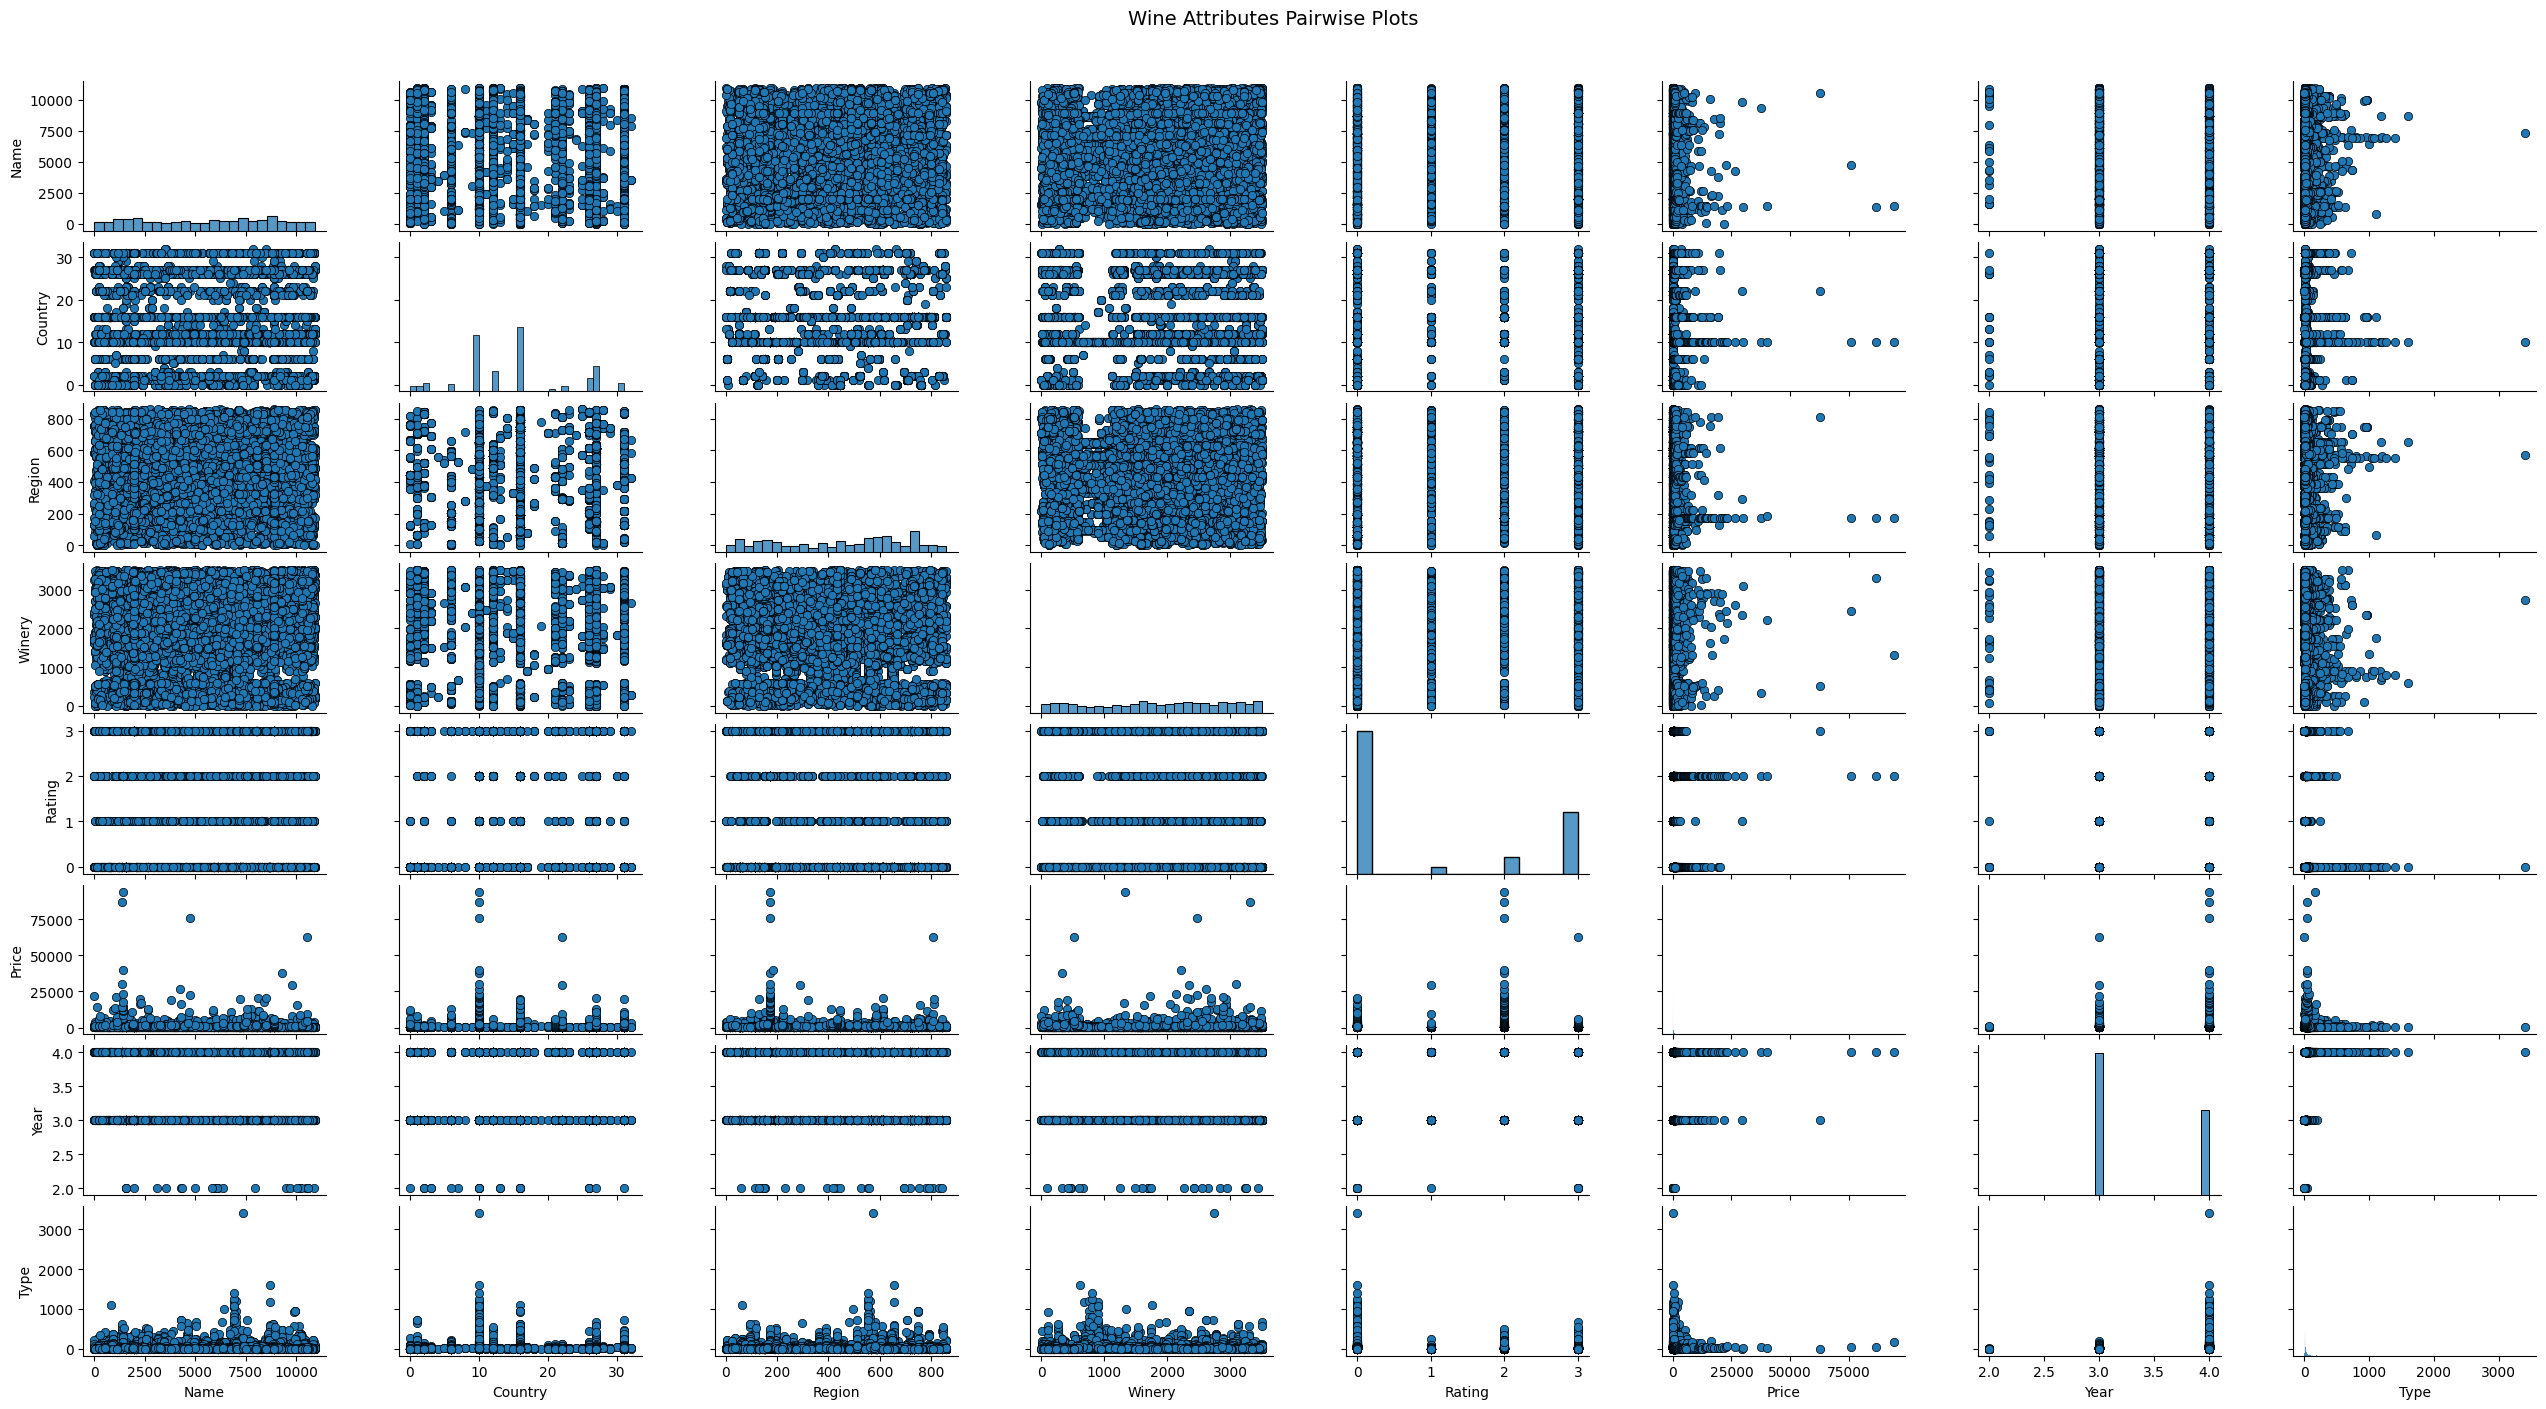

In [192]:
# Scatter Plot with Hue for visualizing data in 3-D
pp = sns.pairplot(winesLabel, size=1.8, aspect=1.8, 
                  palette={"red": "#FF9999", "white": "#FFE888"},
                  plot_kws=dict(edgecolor="black", linewidth=0.5))
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)

# Data cleaning

Before we can do anything with the data, we need to get rid of any noise, missing values, duplicates etc in the dataset..

## Detect null values

The dataset doesn't have null values. If there were any then we would have to remove them and fill the missing spots with new values (by using a missing values algorithm)

In [227]:
wines.isna().sum()

Name               0
Country            0
Region             0
Winery             0
Rating             0
NumberOfRatings    0
Price              0
Year               0
Type               0
dtype: int64

## Remove unwanted values

In [213]:
wines.columns

Index(['Name', 'Country', 'Region', 'Type', 'NumberOfRatings', 'Price',
       'Rating', 'Age'],
      dtype='object')

##### Remove year NV

744 entries have the year "No Vintage". We don't know if NV is always a wine of the same vintage or if this could be a mix from different wine years. It's not clear, so we delete it.

In [228]:
wines[wines.Year == 'N.V.'].count()

Name               744
Country            744
Region             744
Winery             744
Rating             744
NumberOfRatings    744
Price              744
Year               744
Type               744
dtype: int64

In [229]:
wines = wines.drop(wines[wines.Year == 'N.V.'].index)

##### Remove duplicates

Delete any duplicate rows. Duplicates do not add value to machine learning algorithms and will only cause confusion.

In [196]:
wines.shape

(11402, 9)

In [230]:
wines = wines.drop_duplicates()

In [198]:
wines.shape

(11402, 9)

##### Mean per year

A particular wine is made by several wineries in a year, so we should average the price so we don't create confusion and because we want to predict how much the wine itself will cost, not in combination with winery.

In [231]:
wines[wines['Name'] == 'Pomerol 2011']

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,Type
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011,red
1611,Pomerol 2011,France,Pomerol,Château Certan de May,4.1,162,92.61,2011,red
1850,Pomerol 2011,France,Pomerol,Château La Grave (Trigant de Boisset),4.1,174,39.90,2011,red
2238,Pomerol 2011,France,Pomerol,Château Petit-Village,3.9,197,72.62,2011,red
2418,Pomerol 2011,France,Pomerol,Château Latour à Pomerol,4.2,210,90.54,2011,red
7517,Pomerol 2011,France,Pomerol,Château Gombaude-Guillot,4.1,73,55.10,2011,red


In [232]:
wines['Price'] = wines['Price'].groupby([wines['Name'], wines['Country'], wines['Region'], wines['Year'], wines['Type']]).transform('mean') 

We will sum all the 'numberOfRatings' values.

In [233]:
wines['NumberOfRatings2'] = wines['NumberOfRatings'].groupby([wines['Name'], wines['Country'], wines['Region'], wines['Year'], wines['Type']]).transform('sum') 

In [234]:
wines.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year,Type,NumberOfRatings2
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,74.295,2011,red,916
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.500,2017,red,100
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.720,2019,red,100
5,Gigondas (Nobles Terrasses) 2017,France,Gigondas,Vieux Clocher,3.7,100,19.900,2017,red,100
12,Les Obriers de la Peira Terrasses du Larzac 2017,France,Terrasses du Larzac,La Pèira en Damaisèla,4.1,100,14.520,2017,red,100


We will calculate the weighted average for the rating with numberofratings as weights.

In [235]:
wines = wines.groupby(['Name', 'Country','Region', 'Year', 'Type', 'NumberOfRatings2', 'Price'], as_index=False).apply(lambda x: np.average(x.Rating, weights=x.NumberOfRatings))

In [236]:
wines.set_axis(['Name', 'Country', 'Region', 'Year', 'Type', 'NumberOfRatings' , 'Price', 'Rating'], axis=1, inplace=True)

C:\Users\elise\AppData\Local\Temp\ipykernel_19600\102789095.py:1: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  wines.set_axis(['Name', 'Country', 'Region', 'Year', 'Type', 'NumberOfRatings' , 'Price', 'Rating'], axis=1, inplace=True)


##### Remove year from NAME column 

Pomerol 2011 is not the same as Pomerol 2012. These are 2 different wines of which we should be able to see the evolution. We do not have enough data in the dataset for this, as all prices are extracted in 2020, we have no historical data.
We assume here that there is no difference between wines from certain years. We remove the year part of the name column so our prediction model will know we are talking about the same wine.

In [237]:
wines['Name'] = wines['Name'].replace('\s(\d){4}','',regex=True)

In [238]:
wines['Name']

0                           '61 Franciacorta Nature
1            'Giulio Ferrari' Riserva del Fondatore
2            'Giulio Ferrari' Riserva del Fondatore
3       'Giulio Ferrari' Riserva del Fondatore Rosé
4                       'Rosso & Bianco' Chardonnay
                           ...                     
9831                        Μαλαγουζιά (Malagouziá)
9832                                              И
9833                          ‘61 Franciacorta Brut
9834                          ‘61 Franciacorta Rosé
9835                         ‘61 Franciacorta Satèn
Name: Name, Length: 9836, dtype: object

##### Rating and NumberOfRatings column

Rating is 50% correlated with Price, but rating + numberOfRatings can be an indication of price increase or decrease in the future. Higher rated wines will be tried by more people, so demand will be rising.
The rating of wines with a low numberOfRatings is not reliable, we will remove wines with numberOfRatings in the lowest quartile.

In [239]:
wines.head()

,Name,Country,Region,Year,Type,NumberOfRatings,Price,Rating
0,'61 Franciacorta Nature,Italy,Franciacorta,2012,sparkling,163,29.90,4.0
1,'Giulio Ferrari' Riserva del Fondatore,Italy,Trento,2007,sparkling,1191,122.27,4.6
2,'Giulio Ferrari' Riserva del Fondatore,Italy,Trento,2008,sparkling,205,87.50,4.4
3,'Giulio Ferrari' Riserva del Fondatore Rosé,Italy,Trentino,2006,sparkling,66,239.00,4.5
4,'Rosso & Bianco' Chardonnay,United States,California,2016,white,127,17.50,3.7


In [240]:
q = wines.NumberOfRatings.quantile(.25)

wines = wines.loc[(wines.NumberOfRatings > q)]
wines.shape

(7329, 8)

##### Age

We need to add the age of the wine instead of wineyear to get a rising curve.

In [241]:
wines["Year"] = wines["Year"].astype(int)

base = 2020

wines['Age'] = wines['Year'].apply(lambda x: base - x)

#wines = wines.drop(['Year'], axis=1) 

wines.head()

C:\Users\elise\AppData\Local\Temp\ipykernel_19600\4110631180.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wines["Year"] = wines["Year"].astype(int)
C:\Users\elise\AppData\Local\Temp\ipykernel_19600\4110631180.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wines['Age'] = wines['Year'].apply(lambda x: base - x)


,Name,Country,Region,Year,Type,NumberOfRatings,Price,Rating,Age
0,'61 Franciacorta Nature,Italy,Franciacorta,2012,sparkling,163,29.90,4.0,8
1,'Giulio Ferrari' Riserva del Fondatore,Italy,Trento,2007,sparkling,1191,122.27,4.6,13
2,'Giulio Ferrari' Riserva del Fondatore,Italy,Trento,2008,sparkling,205,87.50,4.4,12
3,'Giulio Ferrari' Riserva del Fondatore Rosé,Italy,Trentino,2006,sparkling,66,239.00,4.5,14
4,'Rosso & Bianco' Chardonnay,United States,California,2016,white,127,17.50,3.7,4


## Outliers

Outlier detection is important to detect and remove certain data points that are purely coincidental. For example, due to a very heavy summer, the harvest may have failed in a particular year, which also reflects in the prices.

In order to make outlier detection work with a machine-learning algorithm, we need to have as equal a distribution as possible over the year and the geographical features. so that they are not seen as outliers.
This is not the case in our dataset, we also don't want that as discussed earlier.
So an automated outlier detection is not the best way to go in this case. We will have to analyse the distribution manually.

Since we need a continuous series per wine, the deleted values must be replaced by something else.

#### Isolation forest

We will let isolation forest decide what the outliers are and visualize this in a graph.

In [132]:
wines.head()

,Name,Country,Region,Type,NumberOfRatings,Price,Rating,Age
0,'61 Franciacorta Nature,Italy,Franciacorta,sparkling,163,29.90,4.0,8
1,'Giulio Ferrari' Riserva del Fondatore,Italy,Trento,sparkling,1191,122.27,4.6,13
2,'Giulio Ferrari' Riserva del Fondatore,Italy,Trento,sparkling,205,87.50,4.4,12
3,'Giulio Ferrari' Riserva del Fondatore Rosé,Italy,Trentino,sparkling,66,239.00,4.5,14
4,'Rosso & Bianco' Chardonnay,United States,California,white,127,17.50,3.7,4


In [133]:
label = label(wines.loc[:, ['Name', 'Country', 'Region', 'Age', 'Type']])
v = wines.loc[:, ['NumberOfRatings', 'Price', 'Rating']]

npWines = np.concatenate((label, v), axis=1)
npWines

Index(['Name', 'Country', 'Region', 'Age', 'Type'], dtype='object')


array([[0, 16, 242, ..., 163.0, 29.9, 4.0],
       [1, 16, 606, ..., 1191.0, 122.27, 4.6],
       [1, 16, 606, ..., 205.0, 87.5, 4.4],
       ...,
       [4859, 12, 379, ..., 104.0, 19.5, 4.2],
       [4860, 16, 319, ..., 282.0, 17.95, 3.9],
       [4861, 16, 242, ..., 421.0, 19.9, 3.8999999999999995]],
      dtype=object)

In [134]:
iso = IsolationForest()

y_outliers = iso.fit_predict(npWines)

In [135]:
len(y_outliers[y_outliers == -1])

1255

In [207]:
#transform list to colors
def transform(n):
    if n == -1:
        return 'red'
    else:
        return 'blue'

y_colors = list(map(transform, y_outliers))

##### Year vs price

Here we see 1 clear outlier and a few groups of outliers. We need to investigate these groups further as the increase/decrease in price may have only applied to a particular country or region.
Since there is not a year where all the datapoints are significantly higher or lower than the rest which would mean there was a global event that year.

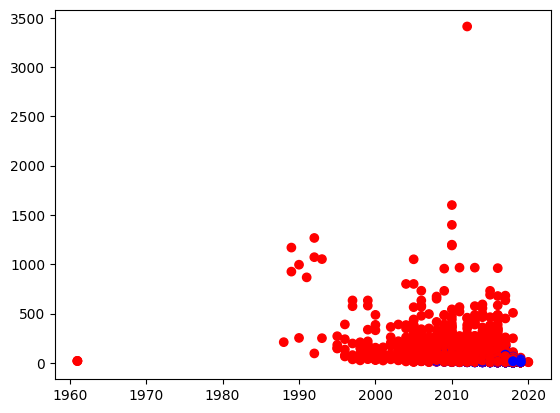

In [208]:
#jaar
X = npWines[:,5]

#prijs
Y = npWines[:,4]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X, Y, color=y_colors)

plt.show()

##### country vs price

We do not extract any meaningful information about outliers here, as the price is strongly period-dependent.

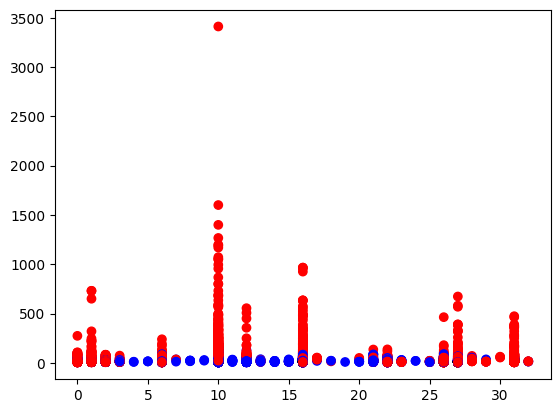

In [210]:
#country
X = npWines[:,1]

#prijs
Y = npWines[:,4]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X, Y, color=y_colors)

plt.show()

##### region vs price

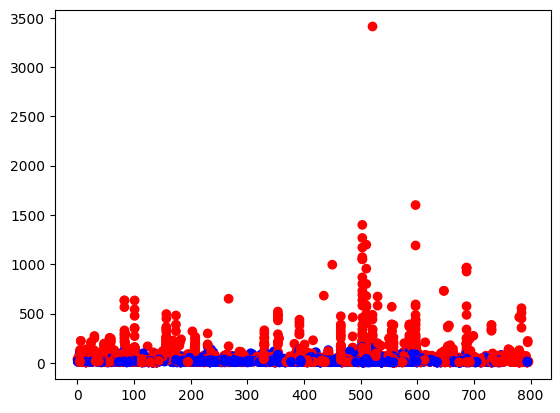

In [211]:
#region
X = npWines[:,2]

#prijs
Y = npWines[:,4]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X, Y, color=y_colors)

plt.show()

##### winery vs price

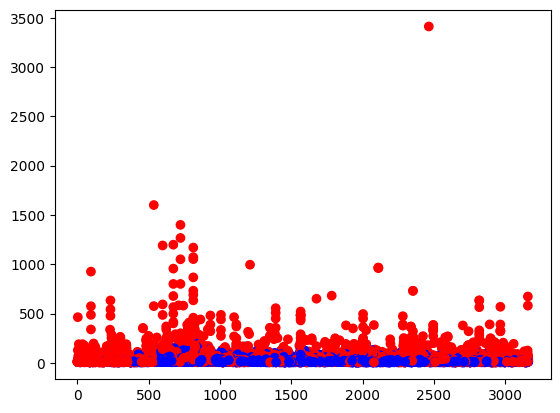

In [212]:
#winery
X = npWines[:,3]

#prijs
Y = npWines[:,4]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(X, Y, color=y_colors)

plt.show()

## Missing values

If we want to predict what price a wine will have in the future, it is necessary that a successive series of data from the past is available.

If we want to predict per region or country, a continuous series is still desirable, but no longer crucial since there will be many other data points for a region/country within a given year.

# Preprocesing

We scale features so that they are standardized. We bring every feature to the same range, so that they can be compared more easily. For categorical vars this is not necessary as there can be no bias as all numbers are subsequent.

In [142]:
npWines[:, 3]
npWines[:, 5]
npWines[:, 7]

array([[0, 16, 242, ..., 2, 163.0, 4.0],
       [1, 16, 606, ..., 2, 1191.0, 4.6],
       [1, 16, 606, ..., 2, 205.0, 4.4],
       ...,
       [4859, 12, 379, ..., 3, 104.0, 4.2],
       [4860, 16, 319, ..., 2, 282.0, 3.9],
       [4861, 16, 242, ..., 2, 421.0, 3.8999999999999995]], dtype=object)

In [143]:
from sklearn import preprocessing
#'Name', 'Country', 'Region', 'Age', 'Type' 'NumberOfRatings', 'Price', 'Rating'
X_train = np.delete(npWines, 6, axis=1)
scaler = preprocessing.StandardScaler().fit(X_train)

scaler.mean_

scaler.scale_

X_scaled = scaler.transform(X_train)
X_scaled

array([[-1.74972526,  0.02014558, -0.55074179, ...,  0.81871896,
        -0.31604257,  0.40945904],
       [-1.74901622,  0.02014558,  1.26709268, ...,  0.81871896,
         0.58370064,  2.47542884],
       [-1.74901622,  0.02014558,  1.26709268, ...,  0.81871896,
        -0.27928263,  1.78677224],
       ...,
       [ 1.69553572, -0.45651923,  0.13344316, ...,  1.56198557,
        -0.36768153,  1.09811564],
       [ 1.69624477,  0.02014558, -0.16619988, ...,  0.81871896,
        -0.21188941,  0.06513074],
       [ 1.69695382,  0.02014558, -0.55074179, ...,  0.81871896,
        -0.09023153,  0.06513074]])

In [228]:
npWines[:,4:6] = X_scaled
npWines

array([[4473, 10, 521, ..., 0.811780871765542, -1.3327692128680084, 0],
       [3447, 10, 366, ..., -0.250226682101622, 0.47469252547525814, 0],
       [469, 16, 53, ..., -0.34079789235595376, 1.0771797715896803, 0],
       ...,
       [5288, 21, 394, ..., -0.3148822363244783, 1.0771797715896803, 3],
       [5288, 21, 394, ..., -0.2582418334515629, 0.7759361485324692, 3],
       [5288, 21, 394, ..., -0.35375572037169145, 1.0771797715896803, 3]],
      dtype=object)

#### labelencoder

In [244]:
wines.columns

Index(['Name', 'Country', 'Region', 'Year', 'Type', 'NumberOfRatings', 'Price',
       'Rating', 'Age'],
      dtype='object')

In [246]:
npWines = label(wines.loc[:, ['Name', 'Country', 'Region','Type']])
npWines = np.concatenate((npWines, wines.loc[:, ['Year','NumberOfRatings', 'Rating', 'Price', 'Age']]), axis=1)
npWines

Index(['Name', 'Country', 'Region', 'Type'], dtype='object')


array([[0, 16, 242, ..., 4.0, 29.9, 8.0],
       [1, 16, 606, ..., 4.6, 122.27, 13.0],
       [1, 16, 606, ..., 4.4, 87.5, 12.0],
       ...,
       [4859, 12, 379, ..., 4.2, 19.5, 3.0],
       [4860, 16, 319, ..., 3.9, 17.95, 59.0],
       [4861, 16, 242, ..., 3.8999999999999995, 19.9, 59.0]], dtype=object)

# Prediction

There are many different ML algorithms but since there is a lack of time we will use kernel ridge regression here. We didn't research each machine learning algorithm yet so it could be that another one is more suited.
We create a model
- by wine
- by country

## lineaire models 

https://scikit-learn.org/stable/modules/linear_model.html

## Kernel ridge regression

### By wine

We exclude region because this feature is correlated with country. We will first fit the model on the whole training data. Normally we would do a lot of train test splits and/or cross validations to tune the hyperparameters. But because of time shortage we will just keep it at the default parameters of the model.

In [247]:
from sklearn.kernel_ridge import KernelRidge
#Name	Country	Region	Type Year	NumberOfRatings		Rating Price	Age

#predict by Name, country, Type, numberofratings, rating, age
y = npWines[:, 7]
#X = np.delete(npWines, 6, axis=1)
X = npWines[:, [0, 1, 3,5,6,8]]
krr = KernelRidge(alpha=1.0)
krr.fit(X, y)

KernelRidge(alpha=1.0)

#### Cross validation

In [152]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(krr, X, y, cv=5)
scores

array([0.20054033, 0.22167378, 0.20188931, 0.18720993, 0.23267194])

In [149]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.21 accuracy with a standard deviation of 0.02


### By country

In this model we will also exclude the name features, as this doesn't give us more information about the country or the wine itself.

In [259]:
from sklearn.kernel_ridge import KernelRidge
#Name	Country	Region	Type Year	NumberOfRatings		Rating Price	Age

#predict by Name, country, Type, numberofratings, rating, age
y = npWines[:, 7]
#X = np.delete(npWines, 6, axis=1)
X = npWines[:, [1, 3,5,6,8]]
krrCountry = KernelRidge(alpha=1.0)
krrCountry.fit(X, y)

KernelRidge(alpha=1.0)

#### Cross validation

In [260]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(krrCountry, X, y, cv=5)
scores

array([0.2593356 , 0.22770063, 0.20814961, 0.18471973, 0.17531428])

In [149]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.21 accuracy with a standard deviation of 0.02


## SVM

https://scikit-learn.org/stable/modules/svm.html

In [18]:
from sklearn import svm
y = redLabel.loc[:, 'Price']
X = redLabel.loc[:, redLabel.columns != 'Price']
regr = svm.SVR()
regr.fit(X, y)

SVR()

In [19]:
regr.predict(X)

array([23.71702467, 21.50899172, 14.25668826, ..., 20.82729097,
       13.42713606, 16.45290367])

## SGD

https://scikit-learn.org/stable/modules/sgd.html

In [20]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

y = redLabel.loc[:, 'Price']
X = redLabel.loc[:, redLabel.columns != 'Price']

reg = make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdregressor', SGDRegressor())])

In [21]:
reg.predict(X)

array([104.33812498,  51.38084084,  18.99489729, ...,  62.72206879,
        -4.25667863,  20.51465628])

## K nearest neighbours

https://scikit-learn.org/stable/modules/neighbors.html

In [22]:
from sklearn.neighbors import KNeighborsRegressor

y = redLabel.loc[:, 'Price']
X = redLabel.loc[:, redLabel.columns != 'Price']

neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y)

KNeighborsRegressor(n_neighbors=2)

In [23]:
neigh.predict(X)

array([63. , 26.5, 15. , ..., 20. , 24.5, 13. ])

## Decision trees

https://scikit-learn.org/stable/modules/tree.html

In [24]:
from sklearn import tree

y = redLabel.loc[:, 'Price']
X = redLabel.loc[:, redLabel.columns != 'Price']

clf = tree.DecisionTreeRegressor()
clf = clf.fit(X, y)

In [25]:
clf.predict(X)

array([95., 15.,  7., ..., 23.,  6.,  7.])

## Neural network

https://scikit-learn.org/stable/modules/neural_networks_supervised.html

# Investment formula

If the future price of all wines in the dataset for a given year is known, we still have to decide how much of our money to invest in which wine.
We will do this by taking into account our starting amount and the probability that that profit (price in year b - price in year 0) will be obtained.

In this stage of the research no suitable variable for the probability of a specific prediction was found, so this is not used in further implementation.

g = amount to invest

wrel = relative profit at a specific point in time

y = score for this wine

$Y = a . P(wrel) . wrel$

### Risk factor

$a = (g)^{wrel}$

this factor must
- rise with increasing g and increasing w
- decrease with increasing g and decreasing w
- to 0 with a decreasing g and an increasing w
- to 0 with a decreasing g and a decreasing w

We take g to the wrel power and not wrel to the g power because otherwise this factor can become very large.
We will also only use the factor for amounts > 100,000 to take risk into account. If your starting capital is large, you can already take more risk for a large profit. We don't use absolute profits because then we can get negative numbers. We have to make the stijging a little bit less abrupt.

Below we see the graphs for wrel in function of y for 2 different g-values.

##### g = 100

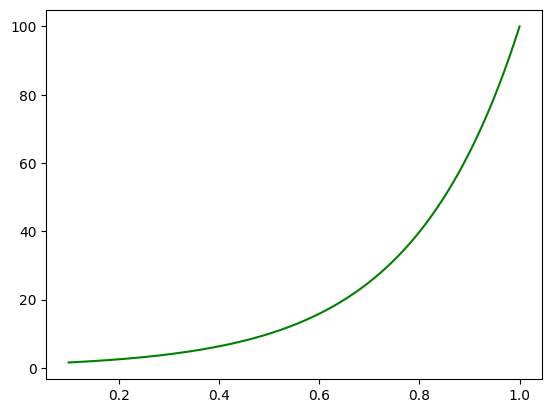

In [154]:
x = np.linspace(0.1,1,1000)

y = ((100)**x)

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x,y, 'g')

# show the plot
plt.show()

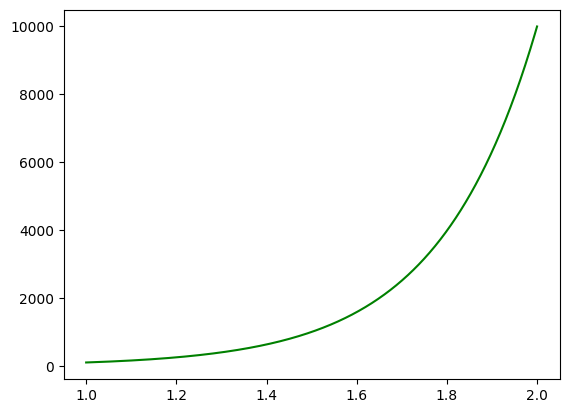

In [155]:
x = np.linspace(1,2,1000)

y = ((100)**x)

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x,y, 'g')

# show the plot
plt.show()

##### g = 100 000

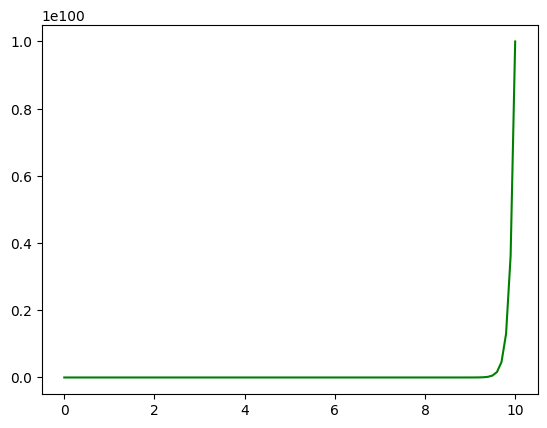

In [158]:
x = np.linspace(0,10,100)

# the function, which is y = x^3 here
y = x**100

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x,y, 'g')

# show the plot
plt.show()

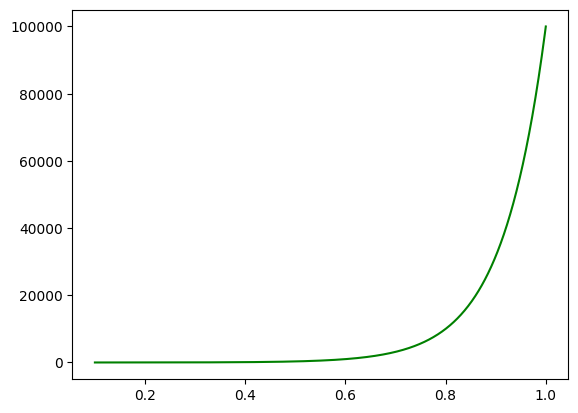

In [157]:
x = np.linspace(0.1,1,1000)

y = ((100000)**x)

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x,y, 'g')

# show the plot
plt.show()

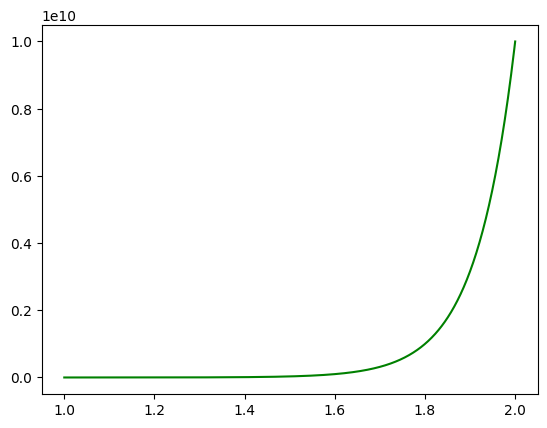

In [25]:
x = np.linspace(1,2,1000)

y = ((100000)**x)

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the function
plt.plot(x,y, 'g')

# show the plot
plt.show()

### Investment calculations

In [265]:
#parameters
#xdict: name --> pred
#base: price coupled with country/wine
#g: startkapitaal
#baseyear: wanneer start de investering
def investment(xdict,g, base):

    #Calculate profit dictionary
    winst = {}

    for b in base.values:
        winst[b[0]] = (xdict[b[0]]/b[1])
    
    #calculate a score by using our inverstment formula for the whole array
    score = {}
    totaal = 0

    for w in winst:
        if g > 100000:
            x = (g**winst[w])*winst[w]
        else:
            x = winst[w]
            
        score[w] = x
        if winst[w] < 1:
            score[w] = 0
            x = 0
        totaal += x
        
    #Calculate the relative scores
    proc = {}

    for s in score:
        #print(score[s]/totaal)
        proc[s] = (score[s]/totaal)
    
    res = {'name': [], 'inzet': [], 'winst': []}
    #res = pd.DataFrame(data=res)
    
    for p in proc:
        res["name"].append(le.incerse_transform(p))
        res['inzet'].append(g * proc[p])
        res['winst'].append((g * proc[p]) * (winst[p] - 1))

    df = pd.DataFrame(data=res)
    
    print(df.sort_values(by=['winst'], inplace=True))
    print("totale winst: " + str(df['winst'].sum()))

#### 1 year

Here we calculate the profit distribution when keeping a wine for 1 year.

##### By wine

In [249]:
cols = ['Name', 'Country', 'Region', 'Type','Year','NumberOfRatings', 'Rating', 'Price', 'Age']
traincols = ['Name', 'Country', 'Type','NumberOfRatings', 'Rating', 'Age']

In [267]:
# creeer predictie vectoren voor alle wijnen
winestemp = pd.DataFrame(npWines,columns=cols)
winestemp['topredictage'] = winestemp['Age'].apply(lambda x: x + 1)
winesx = winestemp.loc[:, (winestemp.columns != 'Price') & (winestemp.columns != 'Age') & (winestemp.columns != 'Region') & (winestemp.columns != 'Year')]
print(winesx.columns)

# maak predicties en houd bij in array
X = winesx.values
        
# maak predicties en houd bij in array
pred = krr.predict(X)

xdict = {}

for i in range(len(pred)):
    xdict[X[i][0]] = pred[i]

# extract prices of the base year 2020
base = winestemp[winestemp['Year'] == str('2020')].loc[:, ['Name','Price']]     

Index(['Name', 'Country', 'Type', 'NumberOfRatings', 'Rating', 'topredictage'], dtype='object')


###### 500 euro

The resulting dataframe will tell us how much money we invest in which wine and how much profit we get after 1 year.

In [268]:
#(xdict,g, base):
investment(xdict, 500, base)

None
totale winst: 0.0


###### 100 000

In [258]:
investment(xdict, 100000, base)

totale winst: 0.0


##### By country

To get an investment calculation by country
- we can use our krrcountry model trained on input data without the wine name feature. We will then have to construct X input data by taking the mean or mode for 'Rating', 'NumberOfRatings', 'Type' etc.. . This way we have one vector for each country.
- or we can just group by country in our previous result (prediction by wine) and sum the 'winst' and 'inzet' columns

In [249]:
cols = ['Name', 'Country', 'Region', 'Type','Year','NumberOfRatings', 'Rating', 'Price', 'Age']
traincols = ['Country', 'Type','NumberOfRatings', 'Rating', 'Age']

#### Multiple years

To know how many years we have to keep our wines, we need to calculate the return for multiple sequential years. This way we can clearly see when it will be at a maximum.

# Conclusion

- How much will a certain wine cost in n years time?
By running our model (for n years) on all wines, we will know the price n years in the future.
- How do we seperate our budget when investing in such wines?
If we have a prediction for the price of all wines n years in the future. We should calculating the profit and assign a score to each prediction. Via the formula we will then know how we should distribute our money.
- In what do we invest to get a big return as fast as possible?
We should calculate the profit by wine for several years. We then divide each profit by the number of years that we invested. This way we can find the maximum profit-by-year and also the best wine to invest in to get a big return in a short time.
- Is the rating important?
the rating is correlated with the price, but rating can also indicate a trend that will occur in the future.